In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import ROOT as r
import sys,math,array,os
import matplotlib.pyplot as plt
r.gROOT.Macro(os.path.expanduser('~/.rootlogon_nystyle.C'))

0L

/home/spark/.rootlogon_nystyle.C:14:11: error: redefinition of 'GloStyle'
  TStyle *GloStyle;
          ^
/home/spark/.rootlogon_nystyle.C:14:11: note: previous definition is here
  TStyle *GloStyle;
          ^


# load bunch of numpy arrays

In [13]:
sigaeloss_bb  = np.load('sigaeloss_numsig_1000_bb.npy')
sigaeloss_bkg = np.load('sigaeloss_numsig_1000_bkg.npy')
mass_bb       = np.load('mass_numsig_1000.npy')
mass_bkg      = np.load('mass_bkg.npy')
bkgaeloss_bb  = np.load('bkgaeloss_numsig_1000.npy')
bkgaeloss_bkg = np.load('bkgaeloss_bkg.npy')

In [14]:
############### DEFAULT CUT BB1 ##############
sigae_wp = .65
bkgae_wp = 2

In [15]:
############### DEFAULT CUT BB2 ##############
sigae_wp = .8
bkgae_wp = 1.8

In [16]:
############### DEFAULT CUT BB3 ##############
sigae_wp = .66
bkgae_wp = 1.7

In [18]:
###CUT 1% Diluted, 1000 signal events
sigae_wp = 0.5
bkgae_wp = 1.5

In [19]:
index_bb = np.where((bkgaeloss_bb>bkgae_wp)&(sigaeloss_bb<sigae_wp))[0]
index_bkg = np.where((bkgaeloss_bkg>bkgae_wp)&(sigaeloss_bkg<sigae_wp))[0]

print(index_bb.shape[0])
print(index_bkg.shape[0])

4943
4022


In [61]:
start = 2800
end = 8000

In [62]:
bins = np.linspace(start,end,(end-start)/100+1,dtype=np.int16)
print(bins)

[2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500
 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900
 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000]


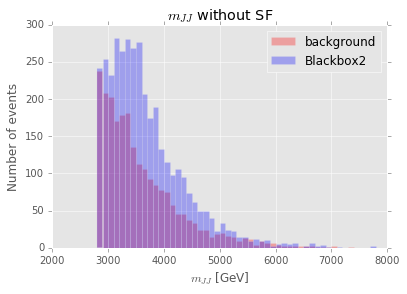

In [63]:
#### Without Scalefactor
#PLOT FOR BLACK BOX 1 with REALNVP
plt.style.use('ggplot')
#bins = np.linspace(1000,8000,71)
bkg_hist = plt.hist(mass_bkg[index_bkg],bins=bins,alpha=0.3,color='r',label='background');
obs_hist = plt.hist(mass_bb[index_bb],bins=bins,alpha=0.3,color='b',label='Blackbox2');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
plt.show()
#plt.axvline(x=38238
#plt.savefig("/data/t3home000/spark/LHCOlympics/plots/NEW_BB3_mjj_massratios_noscalefactor_1dot8_0dot5.png")
# plt.savefig("AnalysisBB2/bkgAEcut_mjj_noscalefactor.png")

# Start Generating Shapes for the Fit

In [64]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = r.RooRealVar("Xshift","Xshift", 1.,0.,200.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 

In [65]:
# Observable
x = r.RooRealVar("x","m_{JJ} [GeV]", 1000,8000)

In [66]:
mygaus = r.TF1("mygaus","TMath::Gaus(x,3500,300)",start,end)
smear_up = r.TF1("smear_up","TMath::Gaus(x,3500,80)",start,end)
smear_down = r.TF1("smear_down","TMath::Gaus(x,3500,600)",start,end)
scale_up = r.TF1("scale_up","TMath::Gaus(x,4000,300)",start,end)
scale_down = r.TF1("scale_down","TMath::Gaus(x,3000,300)",start,end)


roothist_sig = r.TH1F('signal','signal',(end-start)/100,start,end)
roothist_scup = r.TH1F('signal_scaleUp','signal',(end-start)/100,start,end)
roothist_scdown = r.TH1F('signal_scaleDown','signal',(end-start)/100,start,end)
roothist_smup = r.TH1F('signal_smearUp','signal',(end-start)/100,start,end)
roothist_smdown = r.TH1F('signal_smearDown','signal',(end-start)/100,start,end)

roothist_sig.FillRandom("mygaus",1000)
roothist_scup.FillRandom('scale_up',1000)
roothist_scdown.FillRandom('scale_down',1000)
roothist_smup.FillRandom('smear_up',1000)
roothist_smdown.FillRandom('smear_down',1000)


Warning in <TROOT::Append>: Replacing existing TH1: signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_scaleUp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_scaleDown (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_smearUp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_smearDown (Potential memory leak).


In [67]:
roothist_obs = r.TH1F('data_obs','data_obs',(end-start)/100,start,end)
roothist_bkg = r.TH1F('purebkg','purebkg',(end-start)/100,start,end)

Warning in <TROOT::Append>: Replacing existing TH1: data_obs (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: purebkg (Potential memory leak).


In [68]:
for i in range(0,(end-start)/100):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [69]:
f = r.TFile.Open("shapes-blackbox-1000-TH1.root",'recreate')
roothist_sig.Write()
roothist_obs.Write()
roothist_bkg.Write()
roothist_scup.Write()
roothist_scdown.Write()
roothist_smup.Write()
roothist_smdown.Write()

f.Close()

In [ ]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.SetLineColor(r.kRed)
roothist_scup.Draw('same')

roothist_scdown.SetLineColor(r.kBlue)
roothist_scdown.Draw('same')
c11.Draw()

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.Draw('same')
roothist_scdown.Draw('same')
c11.Draw()

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')
f.ls()
f.Close()

In [ ]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
ObsHist.Write()
BkgHist.Write()
iDataHist.Write()

f.Close()

In [ ]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

In [ ]:
smear_up, smear_down = smear(x,iDataHist,0.1)

In [ ]:
def shift(iVar,iDataHist,iShift=5.):
    lInt    = iDataHist.createHistogram("x").Integral()
    lDM     = r.RooRealVar   ("Xdm","Xdm", 0.,-300,300)
    lShift  = r.RooFormulaVar("Xshift",iVar.GetName()+"-Xdm",r.RooArgList(iVar,lDM))
    print(lShift)
    lSPdf   = r.RooHistPdf(iDataHist.GetName()+"P",iDataHist.GetName()+"P", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(iShift)
    lHUp   = lSPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp    = r.RooDataHist(iDataHist.GetName()+"_scaleUp",iDataHist.GetName()+"_scaleUp", r.RooArgList(iVar),lHUp)
    lDM.setVal(-iShift)
    lHDown = lSPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_scaleDown",iDataHist.GetName()+"_scaleDown", r.RooArgList(iVar),lHDown)
    return (lUp,lDown)

In [ ]:
shift_up, shift_down = shift(x,iDataHist,20.0)

In [ ]:
xframe = x.frame()

In [ ]:
a = smear_up.generateBinned("x",100)

In [ ]:
print(h_)

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
c11.Draw()

In [ ]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

In [ ]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

In [ ]:
roothist_obs = r.TH1F('data_obs','data_obs',70,1000,8000)
roothist_bkg = r.TH1F('purebkg','purebkg',70,1000,8000)

In [ ]:
for i in range(0,70):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [ ]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
roothist_sig.Write()
roothist_bkg.Write()
roothist_obs.Write()
smear_up.Write()
smear_down.Write()
shift_up.Write()
shift_down.Write()
f.Close()

In [ ]:
f.Close()

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')

In [ ]:
f.ls()

In [ ]:
f.Close()

In [ ]:
c = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_bkg.Draw()
c.Draw()

In [ ]:
function_gaus = r.TF1("mygaus","TMath::Gaus(x,3823,400)",1000,8000)
roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_sig.FillRandom("mygaus",10000)

In [ ]:
lDM   = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
x     = rt.RooRealVar("x" ,"x", 0.0   ,1000  ,8000)
mean  = rt.RooRealVar("mean",'mean',3823,1000,8000)
sigma = rt.RooRealVar("sigma",'sigma',200,0,500)

In [ ]:
lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
lVar    = iDataHist.createHistogram("x").GetMean()
lInt    = iDataHist.createHistogram("x").Integral()

In [ ]:
iVar = rt.RooRealVar("x","x",3600,1000,8000)
lShift  = rt.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),rt.RooArgList(iVar,lDM))  

In [ ]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    if f2D:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift,fVars[1]),r.RooArgList(iVar,fVars[1]),iDataHist,0)
    else:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 